In [1]:
if (!require("pacman")) install.packages("pacman")
p_load(vroom, ggplot2, dplyr, broom, scales, caret, googledrive, ggpubr, tidyr, cowplot, stringr, fixest)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.6.3"

In [8]:
drive_download(file = as_id("https://drive.google.com/open?id=1cojd2hT5QFTc9Qabyd3vJnpl4uiU--n9"),
  path = "Pubs_Final.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1uAwZfZ_0RKO4tvqIbXQqMNq2MuKmexup"),
  path = "Comp_Final.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1gGR_DMtw9FpvLPnfIC4YwxrS2nXsGb4V"),
  path = "Comp_NSF.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1D0seFYz5EMzdbrxRK3SL45nY_LP7m0XZ"),
  path = "WSC_Pubs_Final.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1xFchfvwLXLw4yuEyIQnaO85xFiFVZzZc"),
  path = "Comp_WSC.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1p47VtjOC87uB33ZOWJqidYort9suOHFv"),
  path = "PubsCited_Final.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1qUoBDeKDqHXEvcXQiEmYia94Ra03J2nm"),
  path = "CompCited_Sample_Final.csv",
  overwrite = TRUE)

pubs = vroom("Pubs_Final.csv", delim=",", col_types = c(citation_count = "i"), altrep = FALSE)
comp = vroom("Comp_Final.csv", delim=",", col_types = c(citation_count = "i"), altrep = FALSE)
nsf = vroom("Comp_NSF.csv", delim=",", col_types = c(citation_count = "i"), altrep = FALSE)
wsc = vroom('WSC_Pubs_Final.csv', delim=",", col_types = c(citation_count = "i"), altrep = FALSE)
wsccomp = vroom('Comp_WSC.csv', delim=",", col_types = c(citation_count = "i"), altrep = FALSE)

pubs = pubs %>% filter(subtype_description %in% c('Article', 'Review'))
comp = comp %>% filter(query %in% pubs$query, subtype_description %in% c('Article', 'Review'))
nsf = nsf %>% filter(query %in% pubs$query, subtype_description %in% c('Article', 'Review'))
# wsc = wsc %>% filter(subtype_description %in% c('Article', 'Review')) # none removed
wsccomp = wsccomp %>% filter(query %in% wsc$query, subtype_description %in% c('Article', 'Review'))

pubscited = vroom("PubsCited_Final.csv", delim=",", col_types = c(.default="c"), altrep = FALSE)
compcited = vroom("CompCited_Sample_Final.csv", delim=",", col_types = c(.default="c"), altrep = FALSE)
pubscited = pubscited %>% filter(EID %in% pubs$eid)
compcited = compcited %>% filter(EID %in% comp$eid)
keep = c("Source", "Field", "SourceQuartile", "Quartile", "CrossIntra", "CiteType", "citation_count", "Dataset", "EID", "eid")
cited_by = rbind(pubscited[,keep], compcited[,keep])

## Normalize citation count by journal issue

In [6]:
keep = c("eid", "citation_count", "query", "Field", "Quartile", "Dataset", "subtype_description", "auth_keywords", "publication_name")
normed = rbind(
  (rbind(pubs[,keep], comp[,keep], nsf[,keep]) %>%
     group_by(tolower(query)) %>%
     mutate(z.mean = mean(citation_count), z.sd = sd(citation_count), std = scale(citation_count))),
  (rbind(wsc[,keep], wsccomp[,keep]) %>%
     group_by(tolower(query)) %>%
     mutate(z.mean = mean(citation_count), z.sd = sd(citation_count), std = scale(citation_count)))
) %>% drop_na(z.sd)

In [9]:
head(normed)

eid,citation_count,query,Field,Quartile,Dataset,subtype_description,auth_keywords,publication_name,tolower(query),z.mean,z.sd,std
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,"<dbl[,1]>"
2-s2.0-84889092764,108,EXACTSRCTITLE(Global Environmental Change) AND VOLUME(23) AND ISSUE(6),NS,Quartile 1,Interdisciplinary,Article,Benthic small-scale fisheries | Chile | Human dimensions | Mexico | Social-ecological system (SES) framework,Global Environmental Change,exactsrctitle(global environmental change) and volume(23) and issue(6),43.44828,40.33838,1.6002558
2-s2.0-84891884316,34,EXACTSRCTITLE(Ecology and Society) AND VOLUME(18) AND ISSUE(4),NS,Quartile 1,Interdisciplinary,Article,Commercialization | Fishing cooperatives | Gulf of California fisheries | Location and co-op choice | Resource stewardship | Self-governance | Small-scale fisheries,Ecology and Society,exactsrctitle(ecology and society) and volume(18) and issue(4),26.13636,19.13306,0.4109973
2-s2.0-84884713045,12,EXACTSRCTITLE(Conservation Biology) AND VOLUME(27) AND ISSUE(5),NS,Quartile 1,Interdisciplinary,Article,NA,Conservation Biology,exactsrctitle(conservation biology) and volume(27) and issue(5),25.88235,16.74023,-0.8292809
2-s2.0-84878910274,22,EXACTSRCTITLE(Ecological Applications) AND VOLUME(23) AND ISSUE(4),NS,Quartile 1,Interdisciplinary,Article,Coupled natural and human systems model | Coupled social-ecological systems | Ecosystem services | Fishing | Human behavior | Life history traits; population modeling | Selective harvest | Size selection,Ecological Applications,exactsrctitle(ecological applications) and volume(23) and issue(4),26.92308,19.33245,-0.2546536
2-s2.0-84873931007,22,EXACTSRCTITLE(Journal of Environmental Management) AND VOLUME(117),NS,Quartile 1,Interdisciplinary,Article,Beyond-BACI analysis | Fisheries management | Gulf of California | Marine protected area | No-take areas | Reef fish assemblages,Journal of Environmental Management,exactsrctitle(journal of environmental management) and volume(117),27.82759,25.80569,-0.2258257
2-s2.0-80052378850,10,EXACTSRCTITLE(Ground Water) AND VOLUME(50) AND ISSUE(1),NS,Quartile 2,Interdisciplinary,Article,NA,Ground Water,exactsrctitle(ground water) and volume(50) and issue(1),27.12500,36.92492,-0.4637789


## Summary statistics

Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."

[1] "mean"


[1] NaN

[1] "median"


[1] NA

[1] ""


[1] 0.7071068

[1] -0.1153879 -0.2752130 -0.8587881  0.3319087 -0.5363354  1.0784298 -1.0966910

[1] "mode"


[1] 0.7071068

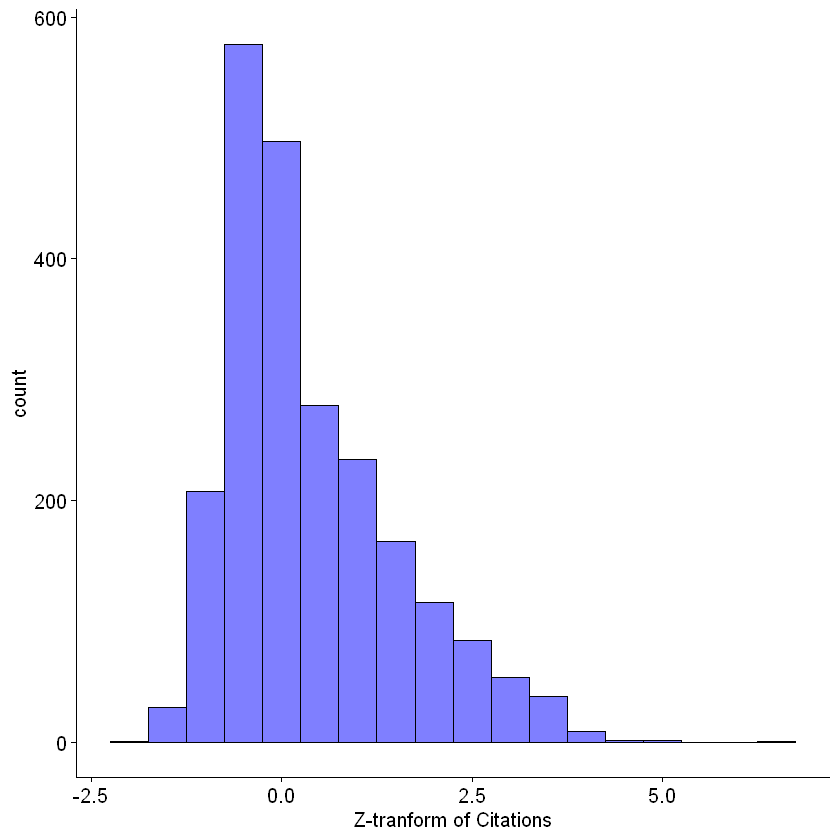

In [10]:
tmp.data <- normed %>%
    mutate(std.pile = ifelse(std > 10, 10, std)) %>%
    filter(Dataset == "Interdisciplinary")
    #filter(Quartile == "Quartile 1")
gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            fill = "blue",
            xlab = "Z-tranform of Citations"
            #add = "mean"
            )
  #+xscale("log2", .format = TRUE)

tmp.data = normed %>% filter(Dataset == "Interdisciplinary")
print('mean')
mean(tmp.data$std)
print('median')
median(tmp.data$std)

print('')
unique(tmp.data$std)[which.max(tabulate(match(tmp.data$std, unique(tmp.data$std))))]
unique(tmp.data$std)[349:355]

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
print('mode')
getmode(tmp.data$std)

In [11]:
tmp.data[tmp.data$std == getmode(tmp.data$std) & tmp.data$Dataset == "Interdisciplinary",]

Warning message:
"The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

eid,citation_count,query,Field,Quartile,Dataset,subtype_description,auth_keywords,publication_name,tolower(query),z.mean,z.sd,std
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,"<dbl[,1]>"
2-s2.0-84887172878,174,EXACTSRCTITLE(Frontiers in Ecology and the Environment) AND VOLUME(11) AND ISSUE(9),NS,Quartile 1,Interdisciplinary,Review,NA,Frontiers in Ecology and the Environment,exactsrctitle(frontiers in ecology and the environment) and volume(11) and issue(9),99.5,105.358910,0.7071068
2-s2.0-84994302308,10,EXACTSRCTITLE(BioScience) AND VOLUME(66) AND ISSUE(10),NS,Quartile 1,Interdisciplinary,Article,community-based monitoring | flowering | invasive species | natural-history collections | public participation in scientific research,BioScience,exactsrctitle(bioscience) and volume(66) and issue(10),6.5,4.949747,0.7071068
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2-s2.0-48249099332,76,EXACTSRCTITLE(Journal of Land Use Science) AND VOLUME(3) AND ISSUE(1),Other,Quartile 1,Interdisciplinary,Article,NA,Journal of Land Use Science,exactsrctitle(journal of land use science) and volume(3) and issue(1),52.5,33.234019,0.7071068
2-s2.0-84884729316,62,EXACTSRCTITLE(Current Opinion in Environmental Sustainability) AND VOLUME(5) AND ISSUE(5),NS,Quartile 1,Interdisciplinary,Review,NA,Current Opinion in Environmental Sustainability,exactsrctitle(current opinion in environmental sustainability) and volume(5) and issue(5),48.0,19.798990,0.7071068
2-s2.0-84907435668,164,EXACTSRCTITLE(Journal of Land Use Science) AND VOLUME(2) AND ISSUE(1),Other,Quartile 1,Interdisciplinary,Article,Agent-based model | Companion modeling | Empirical parameterization | Experiments | Household surveys | Human–environment interactions | Participant observation | Spatial data,Journal of Land Use Science,exactsrctitle(journal of land use science) and volume(2) and issue(1),84.5,112.429978,0.7071068
2-s2.0-79955426473,75,EXACTSRCTITLE(Frontiers in Ecology and the Environment) AND VOLUME(9) AND ISSUE(3),NS,Quartile 1,Interdisciplinary,Review,NA,Frontiers in Ecology and the Environment,exactsrctitle(frontiers in ecology and the environment) and volume(9) and issue(3),61.0,19.798990,0.7071068
2-s2.0-33746375043,38,EXACTSRCTITLE(Eos) AND VOLUME(86) AND ISSUE(42),NS,Quartile 3,Interdisciplinary,Review,NA,Eos,exactsrctitle(eos) and volume(86) and issue(42),25.0,18.384776,0.7071068


## Histogram normalized data

Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1917 rows containing missing values (geom_vline)."

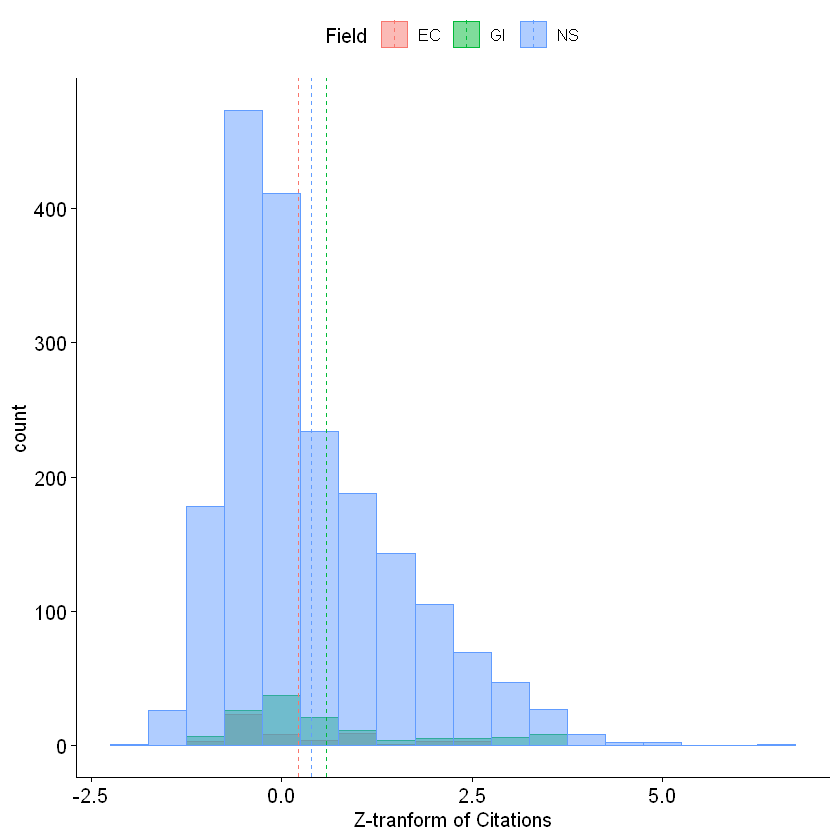

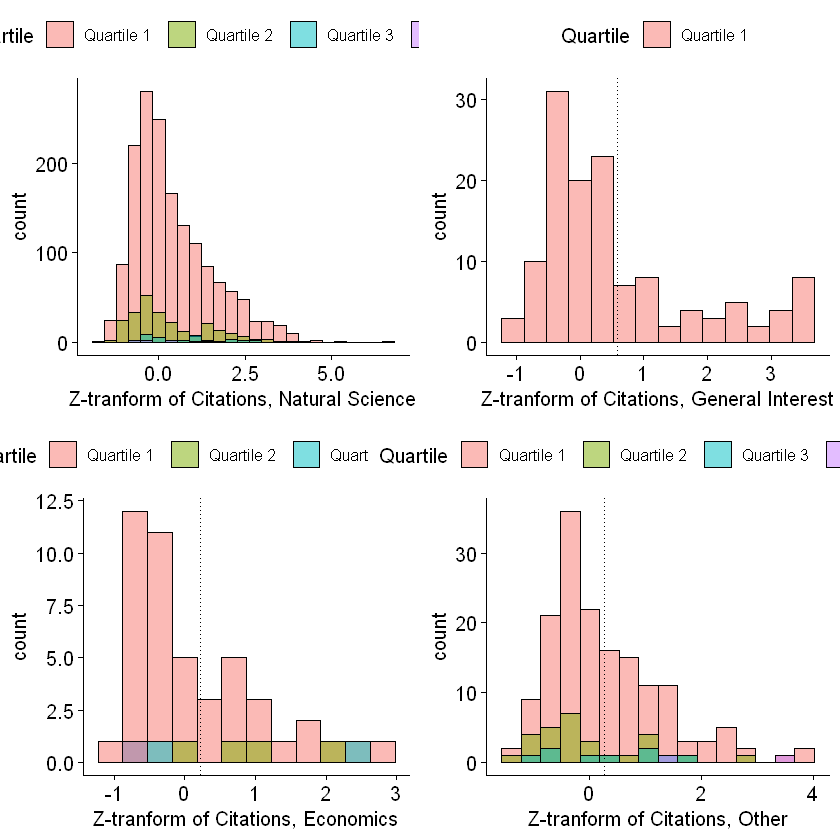

In [12]:
tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field != "Other", Dataset=="Interdisciplinary")
gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            color = "Field", fill = "Field",
            xlab = "Z-tranform of Citations",
            add = "mean"
            ) #+
 #yscale("log2", .format = TRUE)

tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "NS", Dataset=="Interdisciplinary")
ns.hist <- gghistogram(data = tmp.data, x = "std.pile",
                       binwidth = 0.35,
                       #color = "blue",
                       fill = "Quartile",
                       xlab = "Z-tranform of Citations, Natural Science") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="black", linetype="dotted")

tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "GI", Dataset=="Interdisciplinary")%>%
  filter(Quartile != "Missing")
gi.hist <- gghistogram(data = tmp.data, x = "std.pile",
                       binwidth = 0.35,
                       #color = "blue",
                       fill = "Quartile",
                       xlab = "Z-tranform of Citations, General Interest") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="black", linetype="dotted")

tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "EC", Dataset=="Interdisciplinary")
ec.hist <- gghistogram(data = tmp.data, x = "std.pile",
                       binwidth = 0.35,
                       #color = "blue",
                       fill = "Quartile",
                       xlab = "Z-tranform of Citations, Economics") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="black", linetype="dotted")

tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "Other", Dataset=="Interdisciplinary")
o.hist <- gghistogram(data = tmp.data, x = "std.pile",
                      binwidth = 0.35,
                      #color = "blue",
                      fill = "Quartile",
                      xlab = "Z-tranform of Citations, Other") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="black", linetype="dotted")

plot_grid(ns.hist, gi.hist, ec.hist, o.hist)

### Figure 1 from paper

Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1917 rows containing missing values (geom_vline)."

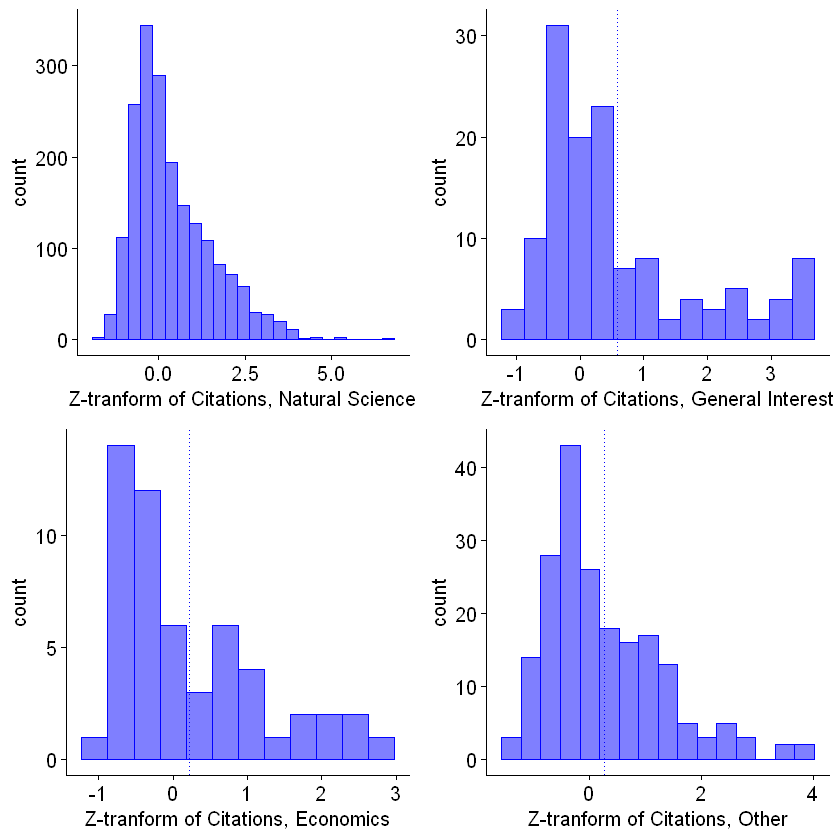

In [30]:
tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "NS", Dataset=="Interdisciplinary")
ns.hist <- gghistogram(data = tmp.data, x = "std.pile",
                       binwidth = 0.35,
                       color = "blue", fill = "blue",
                       xlab = "Z-tranform of Citations, Natural Science") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="blue", linetype="dotted")

tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "GI", Dataset=="Interdisciplinary")%>%
  filter(Quartile != "Missing")
gi.hist <- gghistogram(data = tmp.data, x = "std.pile",
                       binwidth = 0.35,
                       color = "blue", fill = "blue",
                       xlab = "Z-tranform of Citations, General Interest") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="blue", linetype="dotted")

tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "EC", Dataset=="Interdisciplinary")
ec.hist <- gghistogram(data = tmp.data, x = "std.pile",
                       binwidth = 0.35,
                       color = "blue", fill = "blue",
                       xlab = "Z-tranform of Citations, Economics") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="blue", linetype="dotted")

tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "Other", Dataset=="Interdisciplinary")
o.hist <- gghistogram(data = tmp.data, x = "std.pile",
                      binwidth = 0.35,
                      color = "blue", fill = "blue",
                      xlab = "Z-tranform of Citations, Other") + 
    geom_vline(data=tmp.data, aes(xintercept = mean(std)), colour="blue", linetype="dotted")

plot_grid(ns.hist, gi.hist, ec.hist, o.hist)

## Z-score: tables and t-tests

In [14]:
normed$Quartile = factor(normed$Quartile)
levels(normed$Quartile) = list("Quartile 1"=c("Quartile 1"), "Quartile 2-4"=c("Quartile 2", "Quartile 3", "Quartile 4"))
normed %>% group_by(Dataset, Field, Quartile) %>% summarise(Citations=sum(citation_count), Mean=mean(citation_count), "Avg z-score"=mean(std), .groups='keep')
normed %>% group_by(Dataset, Field) %>% summarise(Citations=sum(citation_count), Mean=mean(citation_count), "Avg z-score"=mean(std), .groups='keep')

Dataset,Field,Quartile,Citations,Mean,Avg z-score
<chr>,<chr>,<fct>,<int>,<dbl>,<dbl>
Comparator,EC,Quartile 1,18479,34.800377,-0.001506739
Comparator,EC,Quartile 2-4,490,7.903226,-0.057137269
Comparator,GI,Quartile 1,791142,141.680158,-0.018330717
Comparator,NS,Quartile 1,2813799,29.640777,-0.008118198
Comparator,NS,Quartile 2-4,69799,17.187639,NaN
Comparator,Other,Quartile 1,59347,24.645764,-0.018182399
Comparator,Other,Quartile 2-4,5183,15.753799,-0.017323100
Interdisciplinary,EC,Quartile 1,1742,37.869565,0.146532370
Interdisciplinary,EC,Quartile 2-4,187,23.375000,0.621744712


Dataset,Field,Citations,Mean,Avg z-score
<chr>,<chr>,<int>,<dbl>,<dbl>
Comparator,EC,18969,31.98820,-0.007323085
Comparator,GI,791142,141.68016,-0.018330717
Comparator,NS,2883598,29.12990,NaN
Comparator,Other,64530,23.57691,-0.018079107
Interdisciplinary,EC,1929,35.72222,0.216934198
Interdisciplinary,GI,41774,321.33846,0.582549643
Interdisciplinary,NS,125826,65.63693,NaN
Interdisciplinary,Other,5788,29.23232,0.261992716
NSF,EC,408,24.00000,-0.433638672


In [15]:
signif = function(val) {
  if (val >= 0 && val <= 0.001) {
    return(paste0(round(val, 3), '***'))
  } else if (val > 0.001 && val <= 0.01) {
    return(paste0(round(val, 3), '**'))
  } else if (val > 0.01 && val <= 0.05) {
    return(paste0(round(val, 3), '*'))
  } else if (val > 0.05 && val <= 0.1) {
    return(paste0(round(val, 3), '(.)'))
  } else {
    return(round(val, 3))
  }
}

### CNH vs NSF, top quartile

In [16]:
ttest_results = list()
for (metric in c("citation_count", "std")) {
  for (ds in c("Interdisciplinary")) {
    for (field in c('EC', 'GI', 'NS', 'Other', "All")) {
      if (field == "All") {
        ttest_results[[paste(ds, field, metric, collapse=" ")]] = tidy(t.test((normed %>% filter(Dataset==ds, Quartile=="Quartile 1"))[[metric]],
                                                                              (normed %>% filter(Dataset=="NSF", Quartile=="Quartile 1"))[[metric]],
                                                                              alternative = 'g'))
      } else {
        ttest_results[[paste(ds, field, metric, collapse=" ")]] = tidy(t.test((normed %>% filter(Dataset==ds, Field==field, Quartile=="Quartile 1"))[[metric]],
                                                                              (normed %>% filter(Dataset=="NSF", Field==field, Quartile=="Quartile 1"))[[metric]],
                                                                              alternative = 'g'))
      }
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$Dataset = ds
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$Field = field
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$metric = metric
    }
  }
}
ttest_results = ttest_results %>% bind_rows()
ttest_results$p.value = sapply(ttest_results$p.value, signif)
ttest_results

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Dataset,Field,metric
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10.7362319,37.8695652,27.13333333,0.9751116,0.168,37.20556,-7.8364724,Inf,Welch Two Sample t-test,greater,Interdisciplinary,EC,citation_count
183.9767594,321.3384615,137.36170213,3.4580002,0***,253.20547,96.1438896,Inf,Welch Two Sample t-test,greater,Interdisciplinary,GI,citation_count
37.7554695,73.0024876,35.24701808,10.0470686,0***,2236.81784,31.5717801,Inf,Welch Two Sample t-test,greater,Interdisciplinary,NS,citation_count
14.2591195,33.4591195,19.20000000,3.9503096,0***,268.70778,8.3012814,Inf,Welch Two Sample t-test,greater,Interdisciplinary,Other,citation_count
45.9717829,85.5501801,39.57839721,9.6571012,0***,2966.39114,38.1391555,Inf,Welch Two Sample t-test,greater,Interdisciplinary,All,citation_count
0.5425597,0.1465324,-0.39602736,2.7542310,0.004**,39.63953,0.2107841,Inf,Welch Two Sample t-test,greater,Interdisciplinary,EC,std
0.3937038,0.5825496,0.18884588,2.6121598,0.005**,267.79845,0.1449314,Inf,Welch Two Sample t-test,greater,Interdisciplinary,GI,std
0.3389850,0.3926034,0.05361840,9.9984867,0***,2968.80622,0.2832011,Inf,Welch Two Sample t-test,greater,Interdisciplinary,NS,std
0.3002990,0.2858307,-0.01446835,2.6015002,0.005**,262.95784,0.1097573,Inf,Welch Two Sample t-test,greater,Interdisciplinary,Other,std


### CNH vs Comparator, top quartile

In [17]:
topq = normed %>% filter(Quartile=="Quartile 1")
ttest_results = list()
for (metric in c("citation_count", "std")) {
  for (ds in c("Interdisciplinary", "WSC", "NSF")) {
    for (field in c('EC', 'GI', 'NS', 'Other', "All")) {
      if (field == "All") {
        ttest_results[[paste(ds, field, metric, collapse=" ")]] = tidy(t.test((topq %>% filter(Dataset==ds))[[metric]],
                                                                              (topq %>% filter(Dataset=="Comparator"))[[metric]],
                                                                              alternative = 'g'))
      } else {
        ttest_results[[paste(ds, field, metric, collapse=" ")]] = tidy(t.test((topq %>% filter(Dataset==ds, Field==field))[[metric]],
                                                                              (topq %>% filter(Dataset=="Comparator", Field==field))[[metric]],
                                                                              alternative = 'g'))
      }
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$Dataset = ds
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$Field = field
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$metric = metric
    }
  }
}
ttest_results = ttest_results %>% bind_rows()
ttest_results$p.value = sapply(ttest_results$p.value, signif)
ttest_results

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Dataset,Field,metric
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
3.069188570,37.86956522,34.800376648,0.40180342,0.345,54.513499,-9.71229024,Inf,Welch Two Sample t-test,greater,Interdisciplinary,EC,citation_count
179.658303945,321.33846154,141.680157593,4.32582057,0***,131.161810,110.85894112,Inf,Welch Two Sample t-test,greater,Interdisciplinary,GI,citation_count
43.361710147,73.00248756,29.640777415,12.53350973,0***,1644.114009,37.66786395,Inf,Welch Two Sample t-test,greater,Interdisciplinary,NS,citation_count
8.813355377,33.45911950,24.645764120,2.55088229,0.006**,324.235306,3.11406537,Inf,Welch Two Sample t-test,greater,Interdisciplinary,Other,citation_count
49.951724797,85.55018013,35.598455337,11.74783267,0***,1977.787223,42.95453808,Inf,Welch Two Sample t-test,greater,Interdisciplinary,All,citation_count
-22.300376648,12.50000000,34.800376648,-2.84114226,0.91,1.199567,-59.96120363,Inf,Welch Two Sample t-test,greater,WSC,EC,citation_count
-10.846824260,130.83333333,141.680157593,-0.26118333,0.598,5.083807,-94.22708356,Inf,Welch Two Sample t-test,greater,WSC,GI,citation_count
3.931387534,33.57216495,29.640777415,1.19232749,0.117,197.916323,-1.51759196,Inf,Welch Two Sample t-test,greater,WSC,NS,citation_count
23.754235880,48.40000000,24.645764120,1.38722356,0.118,4.101674,-12.49216519,Inf,Welch Two Sample t-test,greater,WSC,Other,citation_count


### CNH vs Comparator, all quartiles

In [18]:
ttest_results = list()
for (metric in c("citation_count", "std")) {
  for (ds in c("Interdisciplinary", "WSC", "NSF")) {
    for (field in c('EC', 'GI', 'NS', 'Other', "All")) {
      if (field == "All") {
        ttest_results[[paste(ds, field, metric, collapse=" ")]] = tidy(t.test((normed %>% filter(Dataset==ds))[[metric]],
                                                                              (normed %>% filter(Dataset=="Comparator"))[[metric]],
                                                                              alternative = 'g'))
      } else {
        ttest_results[[paste(ds, field, metric, collapse=" ")]] = tidy(t.test((normed %>% filter(Dataset==ds, Field==field))[[metric]],
                    (normed %>% filter(Dataset=="Comparator", Field==field))[[metric]],
                    alternative = 'g'))
      }
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$Dataset = ds
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$Field = field
      ttest_results[[paste(ds, field, metric, collapse=" ")]]$metric = metric
    }
  }
}

ttest_results = ttest_results %>% bind_rows()
ttest_results$p.value = sapply(ttest_results$p.value, signif)
ttest_results

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Dataset,Field,metric
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
3.734027e+00,35.72222222,31.988195616,0.546782871,0.293,64.654275,-7.662111083,Inf,Welch Two Sample t-test,greater,Interdisciplinary,EC,citation_count
1.796583e+02,321.33846154,141.680157593,4.325820569,0***,131.161810,110.858941124,Inf,Welch Two Sample t-test,greater,Interdisciplinary,GI,citation_count
3.650703e+01,65.63693271,29.129900698,12.362366774,0***,1972.241555,31.647368479,Inf,Welch Two Sample t-test,greater,Interdisciplinary,NS,citation_count
5.655414e+00,29.23232323,23.576909024,1.896981491,0.029*,437.688032,0.741260121,Inf,Welch Two Sample t-test,greater,Interdisciplinary,Other,citation_count
4.142879e+01,76.25793823,34.829146008,11.384691794,0***,2351.480674,35.440825484,Inf,Welch Two Sample t-test,greater,Interdisciplinary,All,citation_count
-1.948820e+01,12.50000000,31.988195616,-2.501721660,0.894,1.163807,-58.438558473,Inf,Welch Two Sample t-test,greater,WSC,EC,citation_count
-1.084682e+01,130.83333333,141.680157593,-0.261183330,0.598,5.083807,-94.227083561,Inf,Welch Two Sample t-test,greater,WSC,GI,citation_count
4.642192e+00,33.77209302,29.129900698,1.471636153,0.071(.),219.491128,-0.568396960,Inf,Welch Two Sample t-test,greater,WSC,NS,citation_count
1.675642e+01,40.33333333,23.576909024,1.037017725,0.173,5.116078,-15.640814906,Inf,Welch Two Sample t-test,greater,WSC,Other,citation_count


## Fixed effects model

In [41]:
normed %>%
  filter(str_detect(auth_keywords, 'climate|fish*|forest*')) %>%
  group_by(Dataset, Field) %>% 
  summarise(mean.std=mean(std), mean.citation_count = mean(citation_count))

# make binary variables for keywords
cols <- c("Dataset", "tolower(query)")
tmp.data = normed
fe_mat = tmp.data[,c(cols, "auth_keywords", "std")] %>%
  filter(Dataset=='Interdisciplinary' | Dataset=="Comparator" | Dataset=="NSF") %>% 
  mutate(climate = as.integer(str_detect(auth_keywords, 'climate')),
         fish = as.integer(str_detect(auth_keywords, 'fish*')),
         forest = as.integer(str_detect(auth_keywords, 'forest*')))
fe_mat[cols] = lapply(fe_mat[cols], factor)
fe_mat$std = as.numeric(fe_mat$std)
fe_mat$auth_keywords = NULL
fe_mat[is.na(fe_mat)] = 0
names(fe_mat)[2] = 'query'
sapply(fe_mat, class)

# fixed effects OLS
eqn <- std ~ Dataset + climate + fish + forest + climate:Dataset + fish:Dataset + forest:Dataset | query
fe_model <- feols(data = fe_mat, eqn)
summary(fe_model)

`summarise()` regrouping output by 'Dataset' (override with `.groups` argument)


Dataset,Field,mean.std,mean.citation_count
<chr>,<chr>,<dbl>,<dbl>
Comparator,EC,0.038702946,29.76471
Comparator,GI,0.358204454,106.81250
Comparator,NS,0.013316024,32.11899
Comparator,Other,-0.075837380,17.05376
Interdisciplinary,EC,-0.359547558,9.00000
Interdisciplinary,GI,0.733819308,184.66667
Interdisciplinary,NS,NaN,52.73684
Interdisciplinary,Other,-0.005412126,26.83333
NSF,EC,-0.034058056,1.00000


Dataset     query       std   climate      fish    forest 
 "factor"  "factor" "numeric" "integer" "integer" "integer"

OLS estimation, Dep. Var.: std
Observations: 113,179 
Fixed-effects: query: 2118
Standard-errors: Clustered (query) 
                                  Estimate Std. Error   t value  Pr(>|t|)    
DatasetInterdisciplinary          0.438736   0.027314 16.063000 < 2.2e-16 ***
DatasetNSF                        0.078484   0.022757  3.448700  0.000563 ***
climate                           0.092849   0.051002  1.820500  0.068683 .  
fish                              0.009537   0.056336  0.169297  0.865563    
forest                            0.056498   0.041080  1.375300  0.169028    
DatasetInterdisciplinary:climate  0.013030   0.178137  0.073147  0.941689    
DatasetNSF:climate               -0.096798   0.123922 -0.781116  0.434736    
DatasetInterdisciplinary:fish    -0.532718   0.258277 -2.062600  0.039155 *  
DatasetNSF:fish                   0.037349   0.330622  0.112967  0.910057    
DatasetInterdisciplinary:forest  -0.067387   0.119460 -0.564101  0.572686    
DatasetNSF:forest        

## Mainstream EC z-scores

In [19]:
mainstream_ec = c("Journal of Environmental Economics and Management", "American Journal of Agricultural Economics", "Annual Review of Resource Economics", "Applied Economic Perspectives and Policy", "Environmental and Resource Economics", "Land Economics", "Australian Journal of Agricultural and Resource Economics", "Journal of Agricultural Economics", "Journal of Economic Behavior and Organization", "Journal of Economic Literature", "Journal of Law and Economics", "Journal of Risk and Uncertainty")
# env_ec = c("Agricultural and Resource Economics Review", "American Journal of Agricultural Economics", "Annual Review of Resource Economics", "Australian Journal of Agricultural and Resource Economics", "Climate Change Economics", "Climate Policy", "Ecological Economics", "Economics of Disasters and Climate Change", "Energy Economics", "Energy Journal", "Energy Policy", "Environment and Development Economics", "Environmental and Resource Economics", "Environmental Economics", "Environmental Management", "Economics of Energy and Environmental Policy", "Environmental Science and Policy", "Growth and Change", "International Journal of Ecology & Development", "Journal of Agricultural and Applied Economics", "Journal of Agricultural and Resource Economics", "Journal of Development Economics", "Journal of Environmental Economics and Management", "Journal of Environmental Economics and Policy", "Journal of Environmental Management", "Journal of Environmental Planning and Management", "Journal of the Association of Environmental and Resource Economics", "Land Economics", "Marine Resource Economics", "Resource and Energy Economics", "Review of Environmental Economics and Policy")
normed$journal = tools::toTitleCase(normed$publication_name)
tidy(t.test((normed %>% filter(Dataset=='Interdisciplinary', journal %in% mainstream_ec))$std,
       (normed %>% filter(Dataset=='Comparator', journal %in% mainstream_ec))$std,
       alternative = 'g'))

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.6639882,0.596161,-0.06782716,2.714153,0.006245132,22.59609,0.2443936,Inf,Welch Two Sample t-test,greater


## Gap and t-test

In [20]:
set.seed(42)
subnormed = normed %>% filter(n()>1) %>% mutate(rank = rank(desc(std), ties.method = 'random')) %>% arrange(query)
print("P(I|Top cited)")
normed %>% filter(Dataset=="Interdisciplinary" | Dataset=="Comparator" | Dataset=="NSF") %>%
  group_by(tolower(query)) %>% top_n(1, citation_count) %>% ungroup() %>% 
  group_by(Dataset) %>%
  tally() %>% mutate(percent=percent(n/sum(n)))

print("Stats and t-test")
ttest_results = list()
for (field in c('EC', 'GI', 'NS', 'Other', "All")) {
    if (field == "All") {
        ttest_results[[field]] = tidy(t.test((subnormed %>% filter(rank==1))$citation_count,
                                         (subnormed %>% filter(rank==2))$citation_count,
                                         alternative = 'g'))
        ttest_results[[field]]$sd = mean((subnormed %>% distinct(tolower(query), z.sd))$z.sd, na.rm = T)
    } else {
        ttest_results[[field]] = tidy(t.test((subnormed %>% filter(rank==1, Field==field))$citation_count,
                                             (subnormed %>% filter(rank==2, Field==field))$citation_count,
                                             alternative = 'g'))
        ttest_results[[field]]$sd = mean((subnormed %>% filter(Field==field))$z.sd, na.rm = T)
  }
  ttest_results[[field]]$Field = field
}
ttest_results = ttest_results %>% bind_rows()
ttest_results$p.value = sapply(ttest_results$p.value, signif)
ttest_results

[1] "P(I|Top cited)"


Dataset,n,percent
<chr>,<int>,<chr>
Comparator,1721,77%
Interdisciplinary,396,18%
NSF,104,5%


[1] "Stats and t-test"


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,sd,Field
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
48.30909,110.0727,61.76364,2.726302,0.004**,75.43685,18.80049,Inf,Welch Two Sample t-test,greater,31.86251,EC
550.68182,1209.9545,659.27273,5.072024,0***,193.84918,371.23857,Inf,Welch Two Sample t-test,greater,180.85502,GI
83.99846,178.3744,94.37590,5.003654,0***,2227.91796,56.37412,Inf,Welch Two Sample t-test,greater,30.46839,NS
57.69792,106.7083,49.01042,2.529324,0.006**,208.50041,20.00872,Inf,Welch Two Sample t-test,greater,30.18416,Other
107.51831,229.4955,121.97717,6.523818,0***,2869.17251,80.40091,Inf,Welch Two Sample t-test,greater,55.02229,All


In [21]:
# fields of top-cited articles
normed %>% filter(Dataset=="Interdisciplinary" | Dataset=="Comparator" | Dataset=="NSF") %>%
    group_by(tolower(query)) %>% top_n(1, citation_count) %>% ungroup() %>% 
    group_by(Dataset, Field) %>%
    tally() %>% mutate(percent=percent(n/sum(n)))

Dataset,Field,n,percent
<chr>,<chr>,<int>,<chr>
Comparator,EC,44,2.6%
Comparator,GI,110,6.4%
Comparator,NS,1410,81.9%
Comparator,Other,157,9.1%
Interdisciplinary,EC,11,2.78%
Interdisciplinary,GI,13,3.28%
Interdisciplinary,NS,339,85.61%
Interdisciplinary,Other,33,8.33%
NSF,GI,6,5.8%


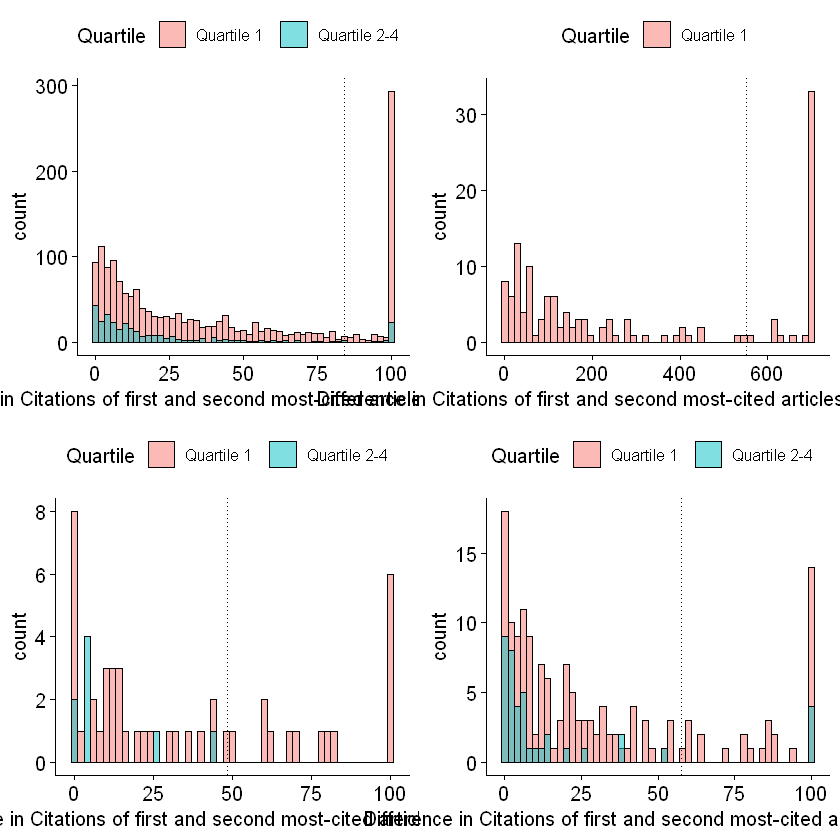

In [22]:
subnormed = normed %>% group_by(tolower(query)) %>% filter(n()>1) %>% mutate(rank = rank(desc(citation_count), ties.method = 'random')) %>% arrange(query)
tmp.data = subnormed %>% filter(rank==1)
tmp.data$difference = tmp.data$citation_count - (subnormed %>% filter(rank==2))$citation_count
tmp.data = tmp.data[,c('Field', 'difference', 'Quartile')]
tmp.data = tmp.data %>% mutate(diff.pile = ifelse(difference > 100, 100, difference))
ns.hist = gghistogram(tmp.data %>% filter(Field=='NS'), x = "diff.pile",
            binwidth = 2,
            #color = "blue",
            fill = "Quartile",
            xlab = "Difference in Citations of first and second most-cited articles, Natural Science") +
  geom_vline(data=tmp.data %>% filter(Field=='NS'), aes(xintercept = mean(difference)), colour="black", linetype="dotted")

ec.hist = gghistogram(tmp.data %>% filter(Field=='EC'), x = "diff.pile",
            binwidth = 2,
            #color = "blue",
            fill = "Quartile",
            xlab = "Difference in Citations of first and second most-cited articles, Economics") +
  geom_vline(data=tmp.data %>% filter(Field=='EC'), aes(xintercept = mean(difference)), colour="black", linetype="dotted")

o.hist = gghistogram(tmp.data %>% filter(Field=='Other'), x = "diff.pile",
            binwidth = 2,
            fill = "Quartile",
            #color = "blue",
            xlab = "Difference in Citations of first and second most-cited articles, Other") +
  geom_vline(data=tmp.data %>% filter(Field=='Other'), aes(xintercept = mean(difference)), colour="black", linetype="dotted")

tmp.data = tmp.data %>% mutate(diff.pile = ifelse(difference > 700, 700, difference))
gi.hist = gghistogram(tmp.data %>% filter(Field=='GI'), x = "diff.pile",
                      binwidth = 700/50,
                      #color = "blue",
                      fill = "Quartile",
                      xlab = "Difference in Citations of first and second most-cited articles, General Interest") +
  geom_vline(data=tmp.data %>% filter(Field=='GI'), aes(xintercept = mean(difference)), colour="black", linetype="dotted")

plot_grid(ns.hist, gi.hist, ec.hist, o.hist)

## CiteScore histograms

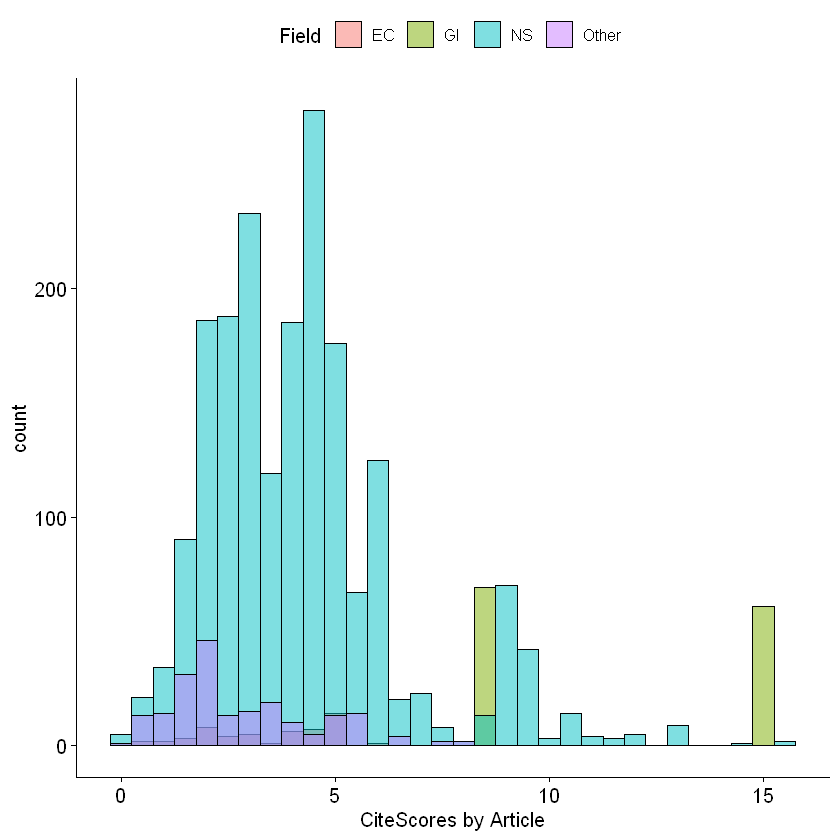

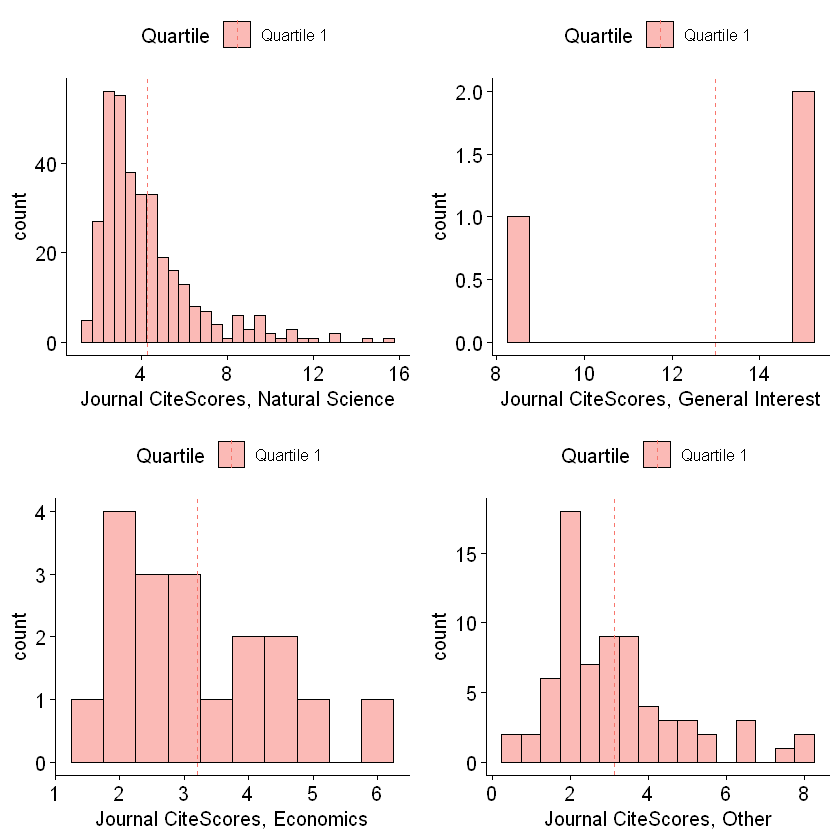

In [23]:
# articles - 2313 - 2 = 2311 items
gghistogram(data = pubs %>% filter(CiteScore < 20), 
            x = "CiteScore",
            binwidth = 0.5,
            fill = "Field",
            xlab = "CiteScores by Article",
            # add = "mean"
)

# journals - 439 items
journals = distinct(pubs %>% filter(CiteScore < 20, Quartile=="Quartile 1"), 
                    publication_name, .keep_all = T)[,c("publication_name", "CiteScore", "Field", "Quartile")]
ns.hist <- gghistogram(data = journals %>% filter(Field=="NS"), x = "CiteScore",
                       binwidth = 0.5,
                       #color = "blue",
                       fill = "Quartile",
                       # xlim=c(0, 20),
                       xlab = "Journal CiteScores, Natural Science",
                       add = "mean")
gi.hist <- gghistogram(data = journals %>% filter(Field=="GI"), x = "CiteScore",
                       binwidth = 0.5,
                       #color = "blue",
                       fill = "Quartile",
                       # xlim=c(0, 20),
                       xlab = "Journal CiteScores, General Interest",
                       add = "mean")
ec.hist <- gghistogram(data = journals %>% filter(Field=="EC"), x = "CiteScore",
                       binwidth = 0.5,
                       #color = "blue",
                       fill = "Quartile",
                       # xlim=c(0, 20),
                       xlab = "Journal CiteScores, Economics",
                       add = "mean"
                       )
o.hist <- gghistogram(data = journals %>% filter(Field=="Other"), x = "CiteScore",
                      binwidth = 0.5,
                      #color = "blue",
                      fill = "Quartile",
                      # xlim=c(0, 20),
                      xlab = "Journal CiteScores, Other",
                      add = "mean")
plot_grid(ns.hist, gi.hist, ec.hist, o.hist)

## Citations in-depth: Intra- and Cross-Disciplinary

### Article counts

In [24]:
normed %>% group_by(Dataset, Field, Quartile) %>% 
  summarise(count = n(), .groups = 'drop_last') %>%
  mutate(percent = percent(count/sum(count)))

Dataset,Field,Quartile,count,percent
<chr>,<chr>,<fct>,<int>,<chr>
Comparator,EC,Quartile 1,531,90%
Comparator,EC,Quartile 2-4,62,10%
Comparator,GI,Quartile 1,5584,100%
Comparator,NS,Quartile 1,94930,96%
Comparator,NS,Quartile 2-4,4061,4%
Comparator,Other,Quartile 1,2408,88%
Comparator,Other,Quartile 2-4,329,12%
Interdisciplinary,EC,Quartile 1,46,85%
Interdisciplinary,EC,Quartile 2-4,8,15%


### Cross/Intra count and percentage of cited-by articles

In [25]:
cited_by %>% group_by(Dataset, Field, CrossIntra) %>%
  summarise(count = n(), .groups='drop_last') %>% 
  mutate(percent = percent(count/sum(count)))

Dataset,Field,CrossIntra,count,percent
<chr>,<chr>,<chr>,<int>,<chr>
Comparator,EC,Cross,2515,66%
Comparator,EC,Intra,1306,34%
Comparator,GI,Cross,2974,58%
Comparator,GI,Intra,2165,42%
Comparator,NS,Cross,107149,24%
Comparator,NS,Intra,337902,76%
Comparator,Other,Cross,26597,90%
Comparator,Other,Intra,2828,10%
Interdisciplinary,EC,Cross,3711,88%


### Count and percentage of cited-by articles by Field

In [26]:
cited_by %>% group_by(Dataset, Field, Source) %>%
  summarise(count = n(), .groups='drop_last') %>% 
  mutate(percent = percent(count/sum(count)))

Dataset,Field,Source,count,percent
<chr>,<chr>,<chr>,<int>,<chr>
Comparator,EC,EC,1310,34.3%
Comparator,EC,GI,301,7.9%
Comparator,EC,NS,2136,55.9%
Comparator,EC,Other,74,1.9%
Comparator,GI,EC,50,1.0%
Comparator,GI,GI,2165,42.1%
Comparator,GI,NS,2744,53.4%
Comparator,GI,Other,180,3.5%
Comparator,NS,EC,4180,0.94%


### Count and percentage of cited-by articles by Source

In [27]:
cited_by %>% group_by(Dataset, Source, Field) %>%
  summarise(count = n(), .groups='drop_last') %>% 
  mutate(percent = percent(count/sum(count)))

Dataset,Source,Field,count,percent
<chr>,<chr>,<chr>,<int>,<chr>
Comparator,EC,EC,1310,20.2%
Comparator,EC,GI,50,0.8%
Comparator,EC,NS,4180,64.5%
Comparator,EC,Other,942,14.5%
Comparator,GI,EC,301,0.4%
Comparator,GI,GI,2165,2.8%
Comparator,GI,NS,70909,91.9%
Comparator,GI,Other,3762,4.9%
Comparator,NS,EC,2136,0.55%


### Count and percentage of cited-by articles by Award

In [19]:
comp_award = merge(comp, pubs[,c('query','award_id')], by='query', all.x=T)
keep = c("Source", "Field", "SourceQuartile", "Quartile", "CrossIntra", "CiteType", "citation_count", "Dataset", "EID", "eid", "award_id")
award = rbind(pubscited[,keep], merge(compcited, comp_award[,c('eid', 'award_id')], by.x='EID', by.y='eid', all.x=T)[,keep])
award %>% group_by(Dataset, award_id, CrossIntra) %>%
    summarize(percentage = n(), .groups='drop_last') %>%
    mutate(percentage = percentage/sum(percentage)) %>%
    ungroup(award_id) %>% group_by(Dataset, CrossIntra) %>%
    summarize(percent = percent(mean(percentage)), .groups='drop_last')

Dataset,CrossIntra,percent
<chr>,<chr>,<chr>
Comparator,Cross,30%
Comparator,Intra,71%
Interdisciplinary,Cross,25%
Interdisciplinary,Intra,76%


In [20]:
award %>% group_by(Dataset, award_id, Source, CrossIntra) %>%
    summarize(percentage = n(), .groups='drop_last') %>%
    mutate(percentage = percentage/sum(percentage)) %>%
    ungroup(award_id) %>% group_by(Dataset, Source, CrossIntra) %>%
    summarize(percent = percent(mean(percentage)), .groups='drop_last')

Dataset,Source,CrossIntra,percent
<chr>,<chr>,<chr>,<chr>
Comparator,EC,Cross,75%
Comparator,EC,Intra,27%
Comparator,GI,Cross,97%
Comparator,GI,Intra,3%
Comparator,NS,Cross,13%
Comparator,NS,Intra,88%
Comparator,Other,Cross,64%
Comparator,Other,Intra,43%
Interdisciplinary,EC,Cross,70%


In [21]:
award %>% group_by(Dataset, award_id, Source, Field) %>%
    summarize(percentage = n(), .groups='drop_last') %>%
    mutate(percentage = percentage/sum(percentage)) %>%
    ungroup(award_id) %>% group_by(Dataset, Source, Field) %>%
    summarize(percent = percent(mean(percentage)), .groups='drop_last')

Dataset,Source,Field,percent
<chr>,<chr>,<chr>,<chr>
Comparator,EC,EC,23%
Comparator,EC,GI,1%
Comparator,EC,NS,61%
Comparator,EC,Other,18%
Comparator,GI,EC,1%
Comparator,GI,GI,3%
Comparator,GI,NS,91%
Comparator,GI,Other,6%
Comparator,NS,EC,2%


## Appendix Table

In [29]:
app.table = normed %>%
  filter(Dataset=="Interdisciplinary" |  Dataset=="Comparator") %>% 
  group_by(journal, Field, Quartile) %>%
  summarise(Interdisciplinary = sum(Dataset == "Interdisciplinary"),
            Comparator = sum(Dataset == "Comparator"),
           "# Unique Issues" = n_distinct(query),
           .groups='drop_last') %>% 
  arrange(desc(Interdisciplinary))

vroom_write(app.table, "Appendix_Table_1.csv", delim = ",")
# vroom_write(app.table %>% group_by(Field) %>% top_n(10, Interdisciplinary),
#        "App_Table_1_top10.csv", delim = ",")

app.table

journal,Field,Quartile,Interdisciplinary,Comparator,# Unique Issues
<chr>,<chr>,<fct>,<int>,<int>,<int>
Proceedings of the National Academy of Sciences of the United States of America,GI,Quartile 1,69,4422,67
Global Change Biology,NS,Quartile 1,54,475,46
Ecological Applications,NS,Quartile 1,39,340,29
Science,GI,Quartile 1,37,725,36
Geophysical Research Letters,NS,Quartile 1,36,1104,35
Ecology,NS,Quartile 1,35,406,31
Ecosystems,NS,Quartile 1,34,131,28
Water Resources Research,NS,Quartile 1,34,644,26
Canadian Journal of Fisheries and Aquatic Sciences,NS,Quartile 1,30,242,24
